# IOPS AI Challenge Dataset

In [1]:
import pandas as pd
import os
from typing import Final
from collections.abc import Callable
import matplotlib.pyplot as plt
from config import data_raw_folder, data_processed_folder
plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
dataset_collection_name = "IOPS"
source_folder = os.path.join(data_raw_folder, "IOPS AI Challenge/KPI Anomaly Detection Final Data Set")
target_folder = data_processed_folder

Metadata handling

In [3]:
# type
DatasetMetadataRecord = {
    "collection_name": str,
    "dataset_name": str,
    "train_path": str,
    "test_path": str,
    "dataset_type": str,
    "datetime_index": bool,
    "split_at": int,
    "train_type": str,
    "train_is_normal": bool,
    "input_type": str,
    "length": int
}

class DatasetMetadata:
    """
    ATTENTION: Not thread-safe! There is no check for changes to the underlying `dataset.csv` file while this class is loaded.
    """
    
    FILENAME: Final[str] = "datasets.csv"
    
    _filepath: str
    _df: pd.DataFrame
    _dirty: bool

    def __init__(self, target_folder: str):
        self._filepath = os.path.join(target_folder, self.FILENAME)
        self._dirty = False
        if not os.path.isfile(self._filepath):
            self._df = self._create_metadata_file()
        else:
            self.refresh(force = True)
    
    def __enter__(self) -> 'DatasetMetadata':
        return self
    
    def __exit__(self, exception_type, exception_value, exception_traceback) -> 'DatasetMetadata':
        self.save()
        return self
    
    def __repr__(self) -> str:
        return repr(self._df)
    
    def __str__(self) -> str:
        return str(self._df)
        
    def _create_metadata_file(self) -> pd.DataFrame:
        df_temp = pd.DataFrame(columns=["dataset_name", "collection_name", "train_path", "test_path", "type", "datetime_index", "split_at", "train_type", "train_is_normal", "input_type", "length"])
        df_temp.set_index(["collection_name", "dataset_name"], inplace=True)
        df_temp.to_csv(self._filepath)
        return df_temp
    
    def add_dataset(self,
        dataset_name: str,
        collection_name: str,
        train_path: str,
        test_path: str,
        dataset_type: str,
        datetime_index: bool,
        split_at: int,
        train_type: str,
        train_is_normal: bool,
        input_type: str,
        dataset_length: int
    ) -> None:
        df_new = pd.DataFrame({
            "train_path": train_path,
            "test_path": test_path,
            "type": dataset_type,
            "datetime_index": datetime_index,
            "split_at": split_at,
            "train_type": train_type,
            "train_is_normal": train_is_normal,
            "input_type": input_type,
            "length": dataset_length
        }, index=[(dataset_collection_name, dataset_name)])
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
    
    def add_datasets(self, datasets: list[DatasetMetadataRecord]) -> None:
        df_new = pd.DataFrame(datasets)
        df_new.set_index(["collection_name", "dataset_name"], inplace = True)
        df = pd.concat([self._df, df_new], axis=0)
        df = df[~df.index.duplicated(keep = "last")]
        self._df = df
        self._dirty = True
    
    def refresh(self, force: bool = False) -> None:
        if not force and self._dirty:
            raise Exception("There are unsaved changes in memory that would get lost by reading from disk again!")
        else:
            self._df = pd.read_csv(self._filepath, index_col=["collection_name", "dataset_name"])
    
    def save(self) -> None:
        self._df.to_csv(self._filepath)
        self._dirty = False

In [4]:
def transform(df: pd.DataFrame, kpi: str) -> pd.DataFrame:
    df = df[df["KPI ID"] == "da10a69f-d836-3baa-ad40-3e548ecf1fbd"].copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    df = df[["timestamp", "value", "label"]]
    df.columns = ["timestamp", "value", "is_anomaly"]
    return df

## Transformation

In [5]:
train_type = "supervised"
train_is_normal = False
input_type = "univariate"
datetime_index = True
dataset_type = "real"

# create target directory
dataset_subfolder = os.path.join(target_folder, input_type, dataset_collection_name)
try:
    os.makedirs(dataset_subfolder)
    print(f"Created directories {dataset_subfolder}")
except FileExistsError:
    print(f"Directories {dataset_subfolder} already exist")
    pass

dm = DatasetMetadata(target_folder)

Created directories data-processed/univariate/IOPS


In [6]:
print("Reading source datasets...")
df_train = pd.read_csv(os.path.join(source_folder, "phase2_train.csv"))
df_test = pd.read_hdf(os.path.join(source_folder, "phase2_ground_truth.hdf"))
df_test["KPI ID"] = df_test["KPI ID"].transform(lambda x: str(x))
dfs = {
    "train": df_train,
    "test": df_test
}
print("...done.\n\nStarting processing...")

for kpi in df_test["KPI ID"].unique():
    dataset_length = 0
    paths = {}

    # transform file
    for t_type in ["train", "test"]:
        filename = f"KPI-{kpi}.{t_type}.csv"
        path = os.path.join(dataset_subfolder, filename)
        paths[t_type] = path
        df_target = transform(dfs[t_type], kpi)
        if t_type == "test":
            dataset_length = len(df_target)
        df_target.to_csv(path, index=False)
        print(f"Processed KPI {kpi} -> {path}")

    dataset_name = kpi

    # save metadata
    dm.add_dataset(
        dataset_name = dataset_name,
        collection_name = dataset_collection_name,
        train_path = paths["train"],
        test_path = paths["test"],
        dataset_type = dataset_type,
        datetime_index = datetime_index,
        split_at = None,
        train_type = train_type,
        train_is_normal = train_is_normal,
        input_type = input_type,
        dataset_length = dataset_length
    )
print("...done.")
dm.save()
print("Metadata saved.")

Reading source datasets...
...done.

Starting processing...
Processed KPI da10a69f-d836-3baa-ad40-3e548ecf1fbd -> data-processed/univariate/IOPS/KPI-da10a69f-d836-3baa-ad40-3e548ecf1fbd.train.csv
Processed KPI da10a69f-d836-3baa-ad40-3e548ecf1fbd -> data-processed/univariate/IOPS/KPI-da10a69f-d836-3baa-ad40-3e548ecf1fbd.test.csv
Processed KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d -> data-processed/univariate/IOPS/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.train.csv
Processed KPI e0747cad-8dc8-38a9-a9ab-855b61f5551d -> data-processed/univariate/IOPS/KPI-e0747cad-8dc8-38a9-a9ab-855b61f5551d.test.csv
Processed KPI ab216663-dcc2-3a24-b1ee-2c3e550e06c9 -> data-processed/univariate/IOPS/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.train.csv
Processed KPI ab216663-dcc2-3a24-b1ee-2c3e550e06c9 -> data-processed/univariate/IOPS/KPI-ab216663-dcc2-3a24-b1ee-2c3e550e06c9.test.csv
Processed KPI 54350a12-7a9d-3ca8-b81f-f886b9d156fd -> data-processed/univariate/IOPS/KPI-54350a12-7a9d-3ca8-b81f-f886b9d156fd.t

In [7]:
dm.refresh()
dm._df.loc[dataset_collection_name]

,train_path,test_path,type,datetime_index,split_at,train_type,train_is_normal,input_type,length
dataset_name,,,,,,,,,
da10a69f-d836-3baa-ad40-3e548ecf1fbd,data-processed/univariate/IOPS/KPI-da10a69f-d8...,data-processed/univariate/IOPS/KPI-da10a69f-d8...,real,True,NaN,supervised,False,univariate,107167
e0747cad-8dc8-38a9-a9ab-855b61f5551d,data-processed/univariate/IOPS/KPI-e0747cad-8d...,data-processed/univariate/IOPS/KPI-e0747cad-8d...,real,True,NaN,supervised,False,univariate,107167
ab216663-dcc2-3a24-b1ee-2c3e550e06c9,data-processed/univariate/IOPS/KPI-ab216663-dc...,data-processed/univariate/IOPS/KPI-ab216663-dc...,real,True,NaN,supervised,False,univariate,107167
54350a12-7a9d-3ca8-b81f-f886b9d156fd,data-processed/univariate/IOPS/KPI-54350a12-7a...,data-processed/univariate/IOPS/KPI-54350a12-7a...,real,True,NaN,supervised,False,univariate,107167
a8c06b47-cc41-3738-9110-12df0ee4c721,data-processed/univariate/IOPS/KPI-a8c06b47-cc...,data-processed/univariate/IOPS/KPI-a8c06b47-cc...,real,True,NaN,supervised,False,univariate,107167
0efb375b-b902-3661-ab23-9a0bb799f4e3,data-processed/univariate/IOPS/KPI-0efb375b-b9...,data-processed/univariate/IOPS/KPI-0efb375b-b9...,real,True,NaN,supervised,False,univariate,107167
c02607e8-7399-3dde-9d28-8a8da5e5d251,data-processed/univariate/IOPS/KPI-c02607e8-73...,data-processed/univariate/IOPS/KPI-c02607e8-73...,real,True,NaN,supervised,False,univariate,107167
301c70d8-1630-35ac-8f96-bc1b6f4359ea,data-processed/univariate/IOPS/KPI-301c70d8-16...,data-processed/univariate/IOPS/KPI-301c70d8-16...,real,True,NaN,supervised,False,univariate,107167
7103fa0f-cac4-314f-addc-866190247439,data-processed/univariate/IOPS/KPI-7103fa0f-ca...,data-processed/univariate/IOPS/KPI-7103fa0f-ca...,real,True,NaN,supervised,False,univariate,107167


## Experimentation

In [8]:
os.listdir(source_folder)

['phase2_train.csv', 'phase2_ground_truth.hdf']

In [9]:
train = pd.read_csv("data-raw/IOPS AI Challenge/KPI Anomaly Detection Final Data Set/phase2_train.csv")

In [10]:
test = pd.read_hdf("data-raw/IOPS AI Challenge/KPI Anomaly Detection Final Data Set/phase2_ground_truth.hdf")

In [11]:
test["KPI ID"] = test["KPI ID"].transform(lambda x: str(x))
test

,timestamp,value,label,KPI ID
107717,1482940800,0.048066,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107718,1482940860,0.010651,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107719,1482940920,0.014996,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107720,1482940980,0.039722,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
107721,1482941040,0.022452,0,da10a69f-d836-3baa-ad40-3e548ecf1fbd
...,...,...,...,...
295409,1508984160,34.940000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295410,1508984220,35.200000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295411,1508984280,33.020000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114
295412,1508984340,35.150000,0,42d6616d-c9c5-370a-a8ba-17ead74f3114


In [12]:
test["KPI ID"].unique()

array(['da10a69f-d836-3baa-ad40-3e548ecf1fbd',
       'e0747cad-8dc8-38a9-a9ab-855b61f5551d',
       'ab216663-dcc2-3a24-b1ee-2c3e550e06c9',
       '54350a12-7a9d-3ca8-b81f-f886b9d156fd',
       'a8c06b47-cc41-3738-9110-12df0ee4c721',
       '0efb375b-b902-3661-ab23-9a0bb799f4e3',
       'c02607e8-7399-3dde-9d28-8a8da5e5d251',
       '301c70d8-1630-35ac-8f96-bc1b6f4359ea',
       '7103fa0f-cac4-314f-addc-866190247439',
       '4d2af31a-9916-3d9f-8a8e-8a268a48c095',
       '6a757df4-95e5-3357-8406-165e2bd49360',
       'ffb82d38-5f00-37db-abc0-5d2e4e4cb6aa',
       '57051487-3a40-3828-9084-a12f7f23ee38',
       'f0932edd-6400-3e63-9559-0a9860a1baa9',
       '431a8542-c468-3988-a508-3afd06a218da',
       '1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0',
       'c69a50cf-ee03-3bd7-831e-407d36c7ee91',
       '05f10d3a-239c-3bef-9bdc-a2feeb0037aa',
       '847e8ecc-f8d2-3a93-9107-f367a0aab37d',
       '6efa3a07-4544-34a0-b921-a155bd1a05e8',
       '43115f2a-baeb-3b01-96f7-4ea14188343c',
       '9c639

In [13]:
transform(train, "da10a69f-d836-3baa-ad40-3e548ecf1fbd")

,timestamp,value,is_anomaly
0,2016-10-14 16:00:00,0.012604,0
1,2016-10-14 16:01:00,0.017786,0
2,2016-10-14 16:02:00,0.012014,0
3,2016-10-14 16:03:00,0.017062,0
4,2016-10-14 16:04:00,0.023632,0
...,...,...,...
107712,2016-12-28 15:55:00,0.073824,0
107713,2016-12-28 15:56:00,0.024778,0
107714,2016-12-28 15:57:00,0.037530,0
107715,2016-12-28 15:58:00,0.020977,0


In [14]:
transform(test, "da10a69f-d836-3baa-ad40-3e548ecf1fbd")

,timestamp,value,is_anomaly
107717,2016-12-28 16:00:00,0.048066,0
107718,2016-12-28 16:01:00,0.010651,0
107719,2016-12-28 16:02:00,0.014996,0
107720,2016-12-28 16:03:00,0.039722,0
107721,2016-12-28 16:04:00,0.022452,0
...,...,...,...
214879,2017-03-13 15:55:00,0.024097,0
214880,2017-03-13 15:56:00,0.009231,0
214881,2017-03-13 15:57:00,0.008676,0
214882,2017-03-13 15:58:00,0.029228,0


In [15]:
train_dfs = [x for _, x in train.groupby("KPI ID")]
train_dfs[0]

,timestamp,value,label,KPI ID
1366509,1491041280,35.03,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1366510,1491041340,36.60,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1366511,1491041400,32.79,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1366512,1491041460,34.28,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1366513,1491041520,34.69,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
...,...,...,...,...
1512759,1500012600,36.84,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1512760,1500012660,38.61,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1512761,1500012720,37.42,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
1512762,1500012780,37.58,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa


In [16]:
test_dfs = [x for _, x in test.groupby("KPI ID")]
test_dfs[0]

,timestamp,value,label,KPI ID
146255,1500012900,37.15,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
146256,1500012960,36.74,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
146257,1500013020,37.59,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
146258,1500013080,38.11,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
146259,1500013140,38.13,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
...,...,...,...,...
295380,1508984160,34.83,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
295381,1508984220,34.31,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
295382,1508984280,37.42,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa
295383,1508984340,36.29,0,05f10d3a-239c-3bef-9bdc-a2feeb0037aa


In [17]:
train_kpis = train["KPI ID"].unique()
test_kpis = test["KPI ID"].unique()
set(test) - set(train)

set()

/opt/miniconda3/envs/akita-jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


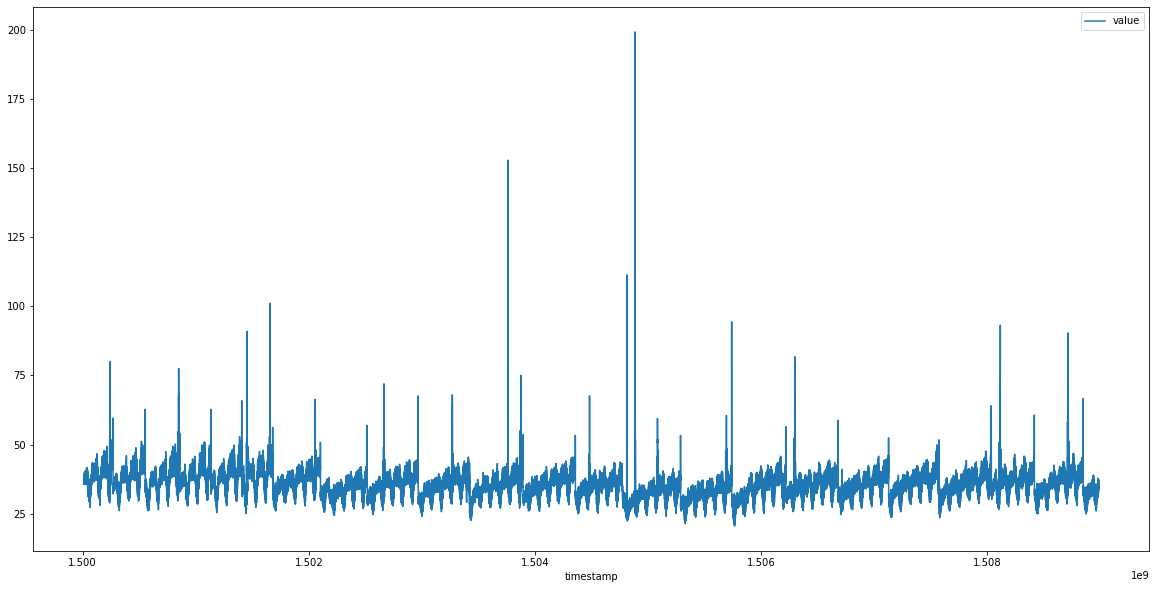

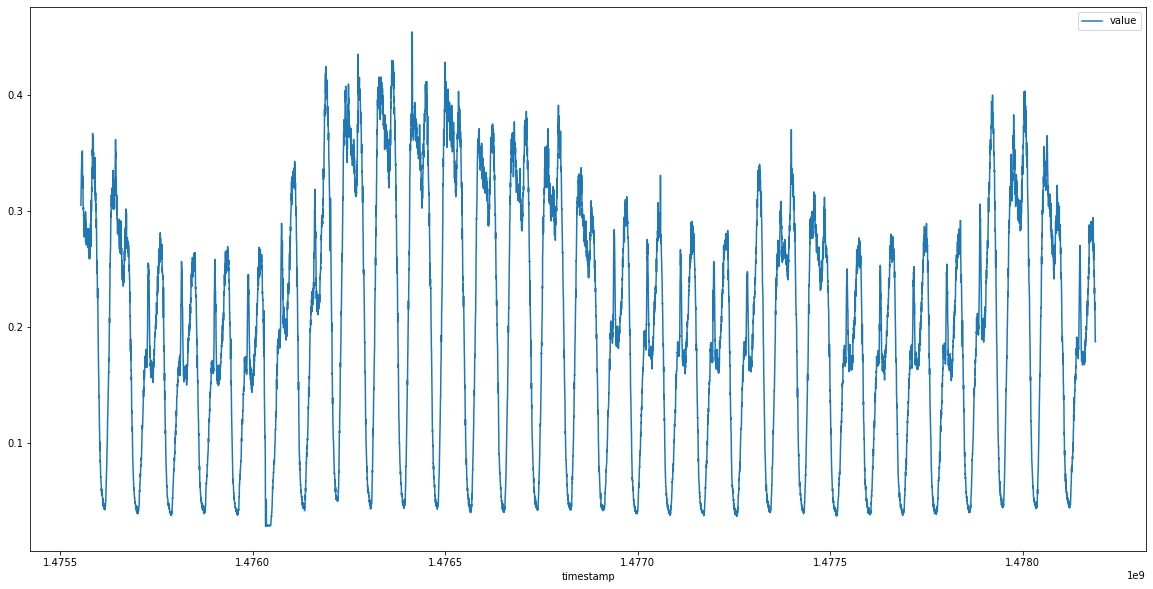

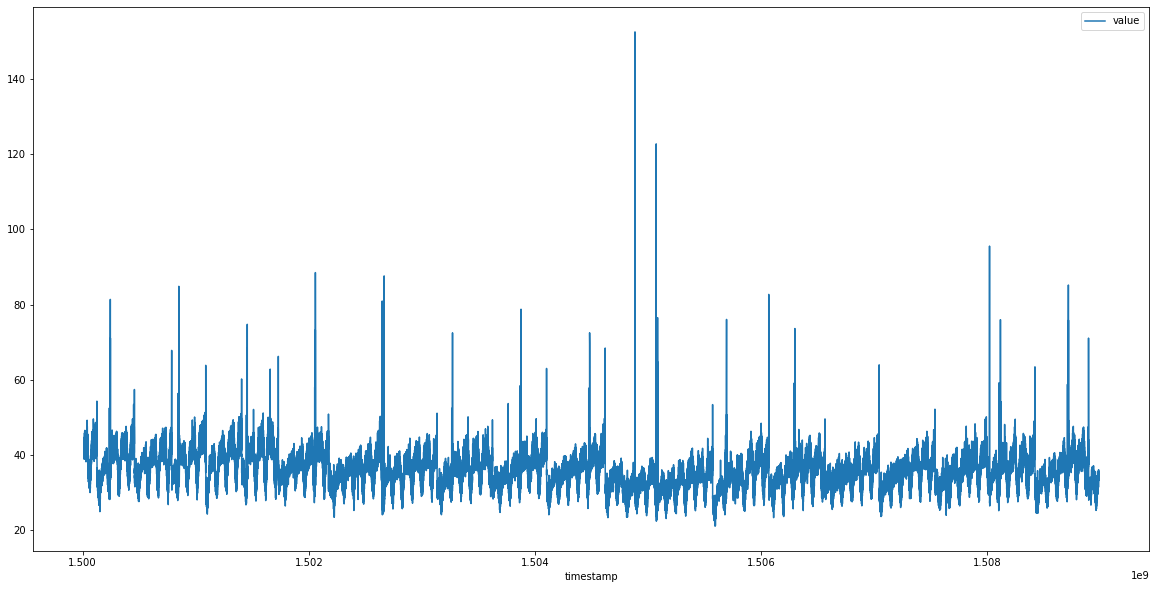

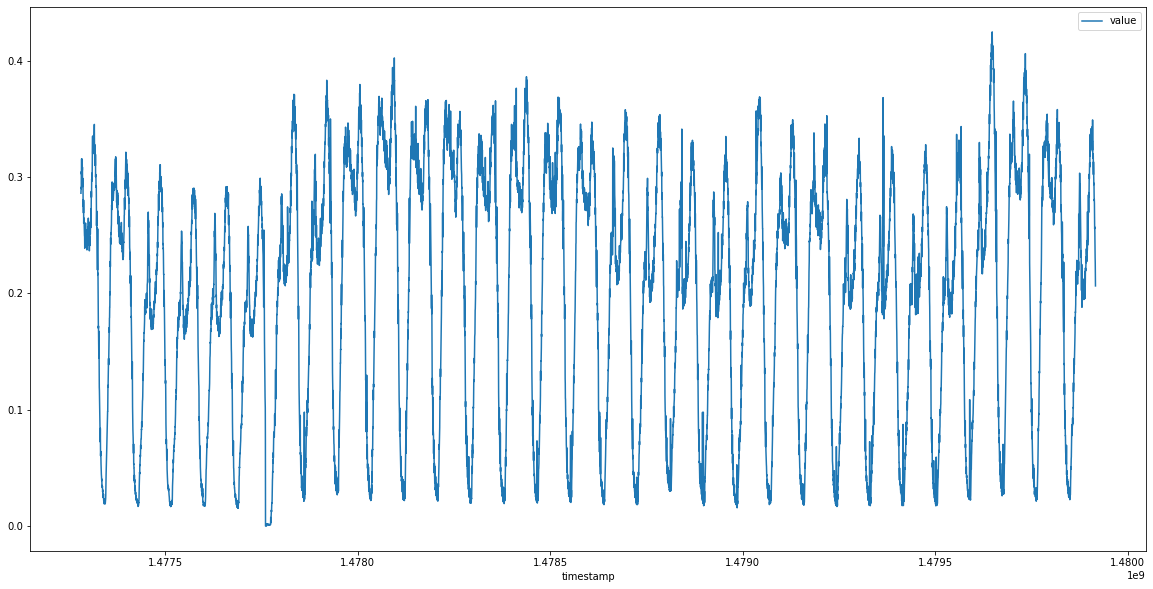

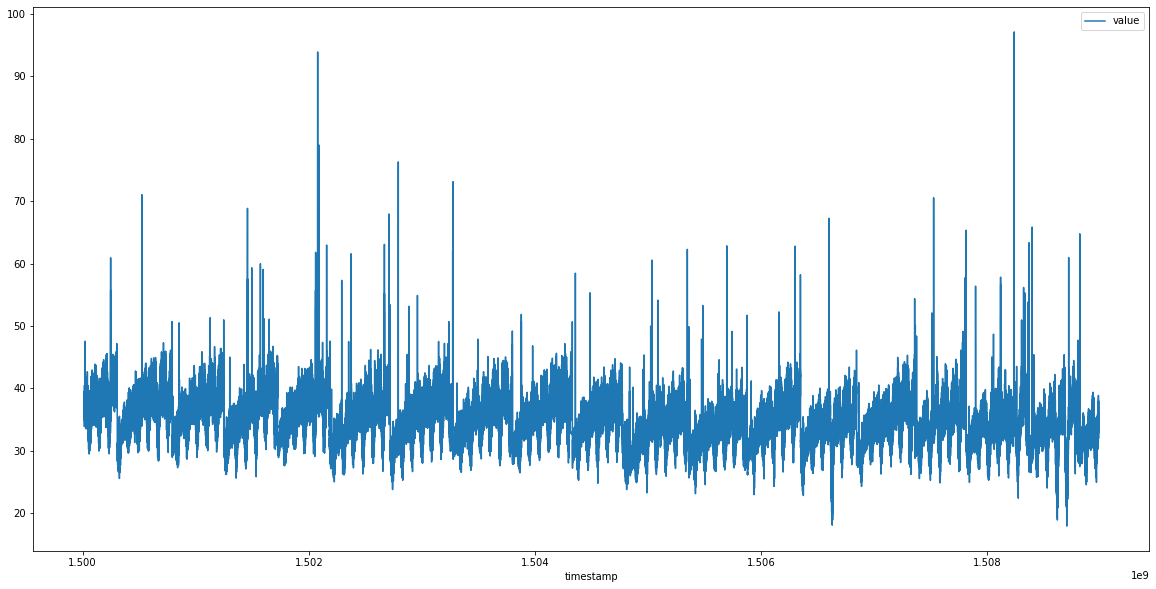

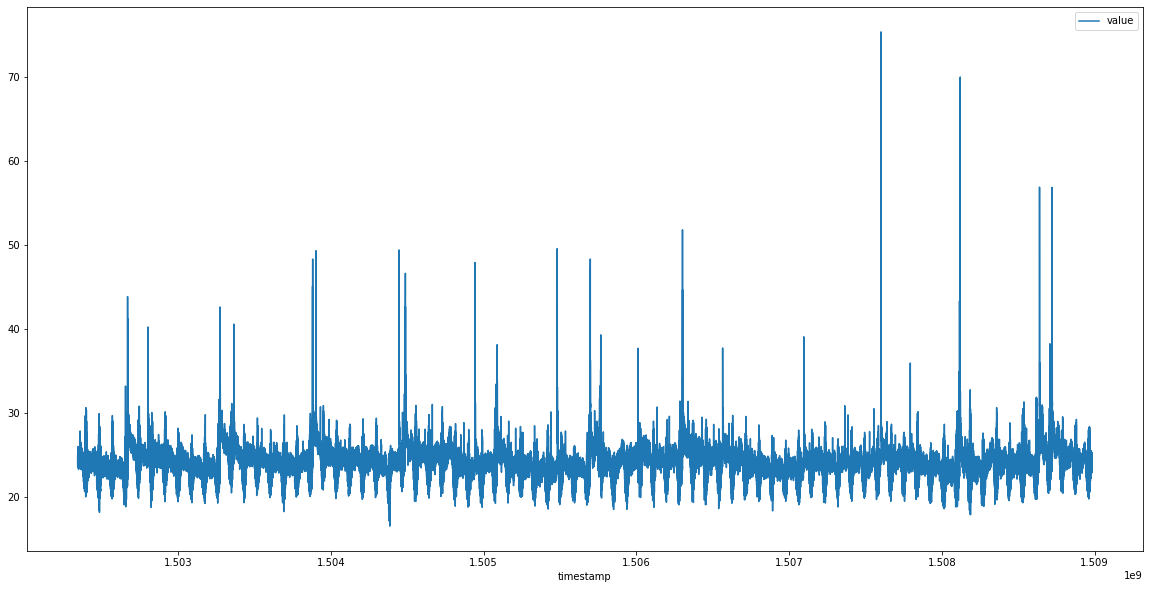

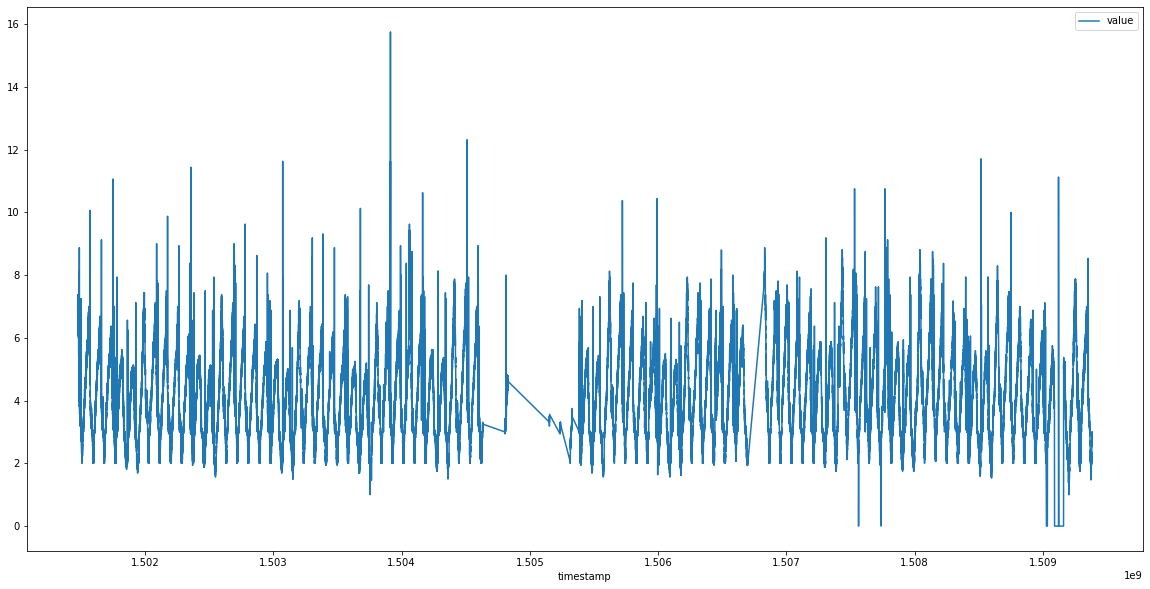

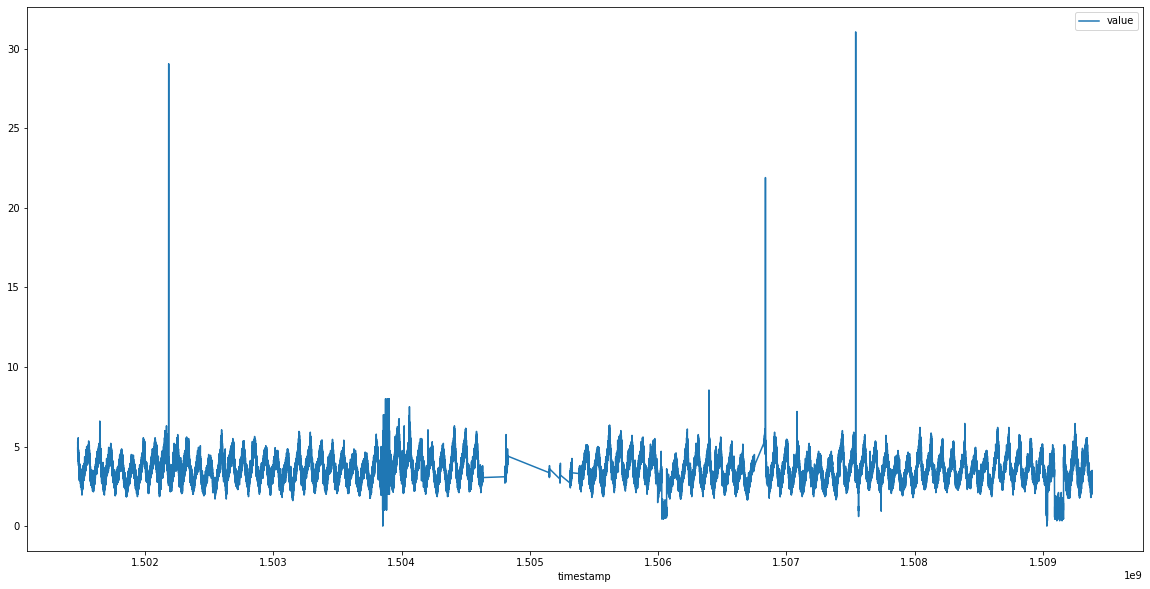

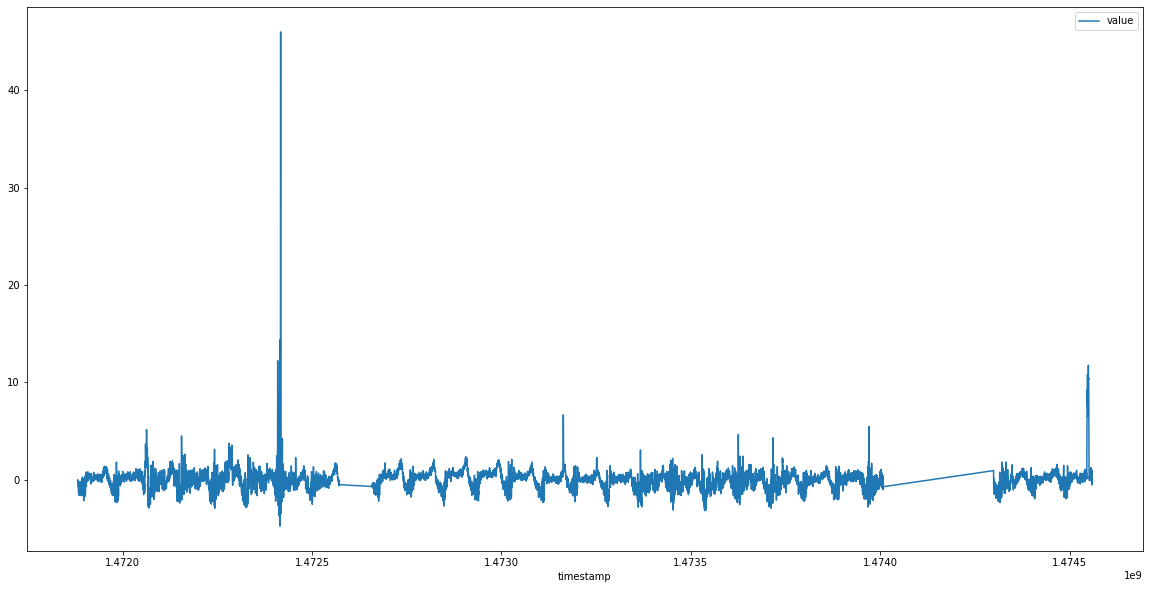

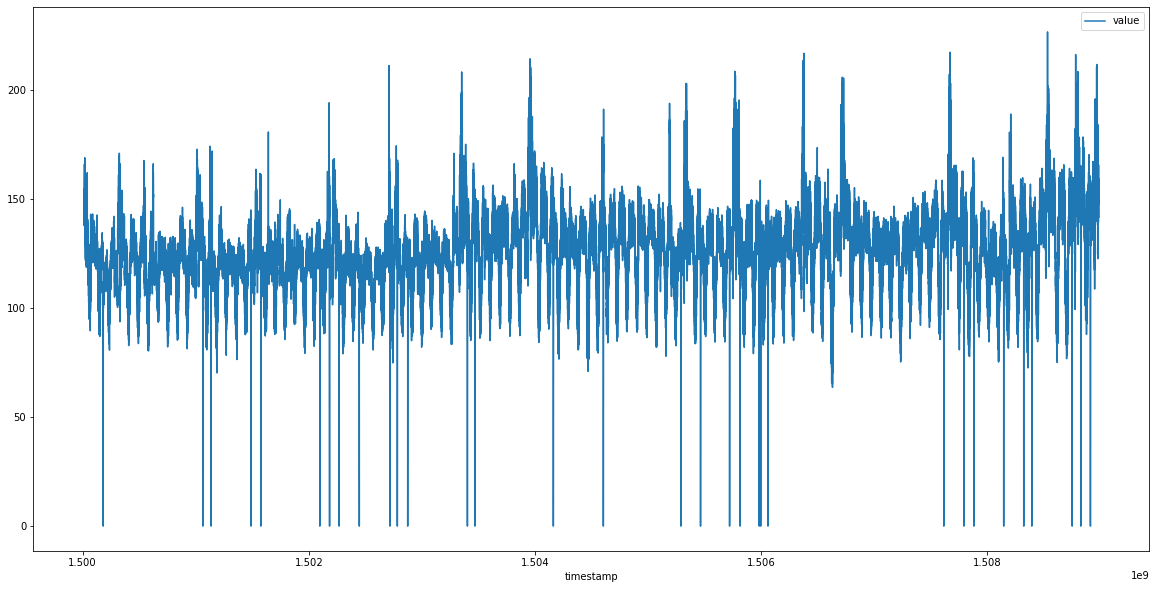

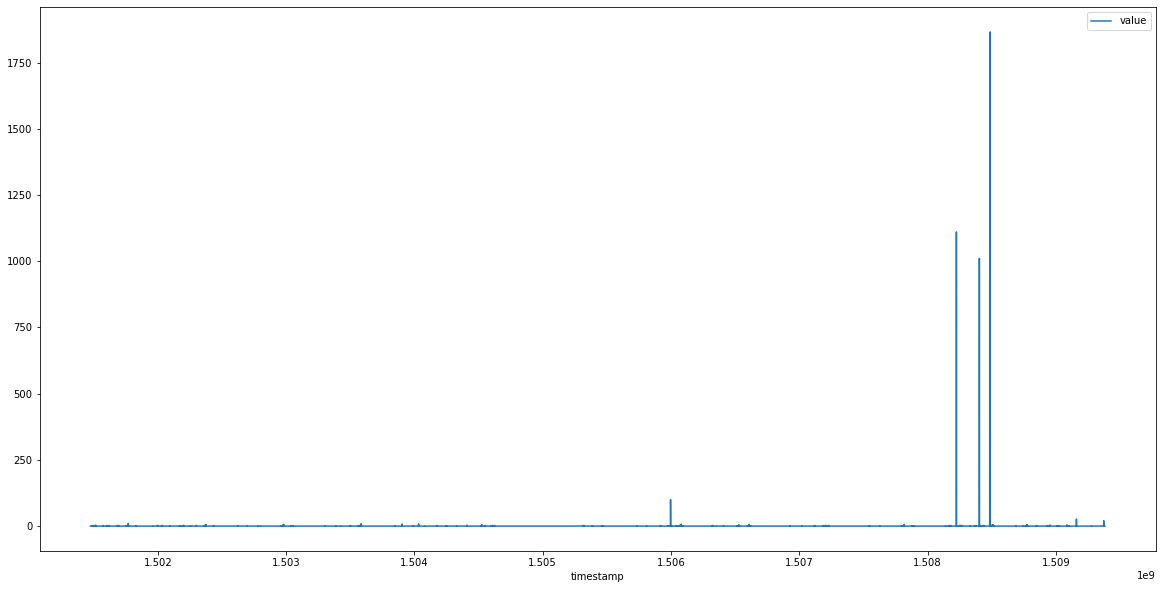

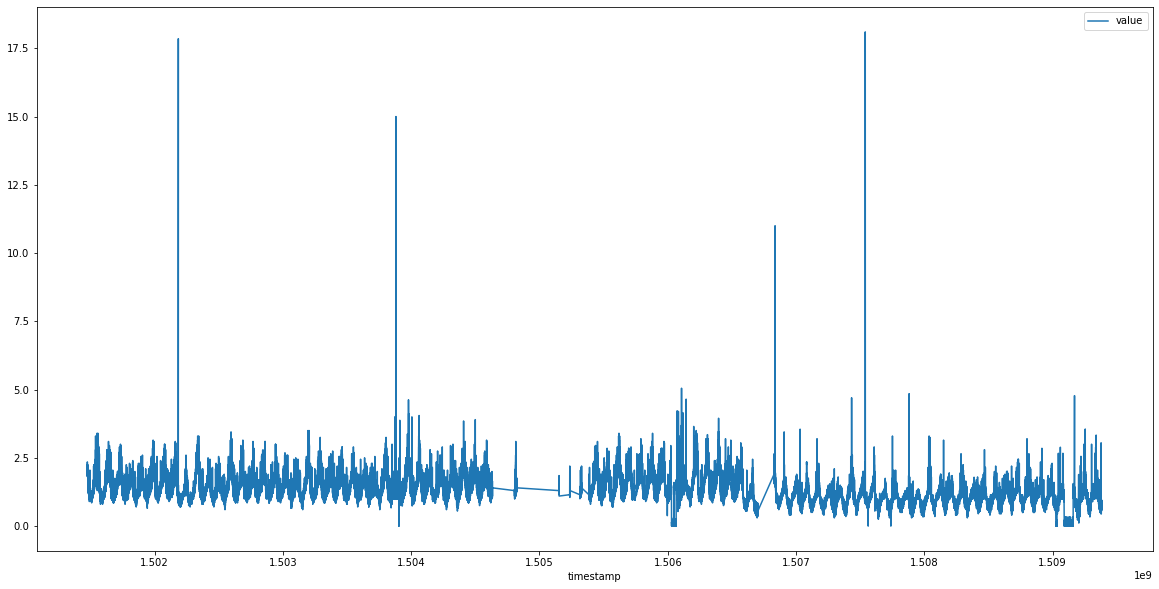

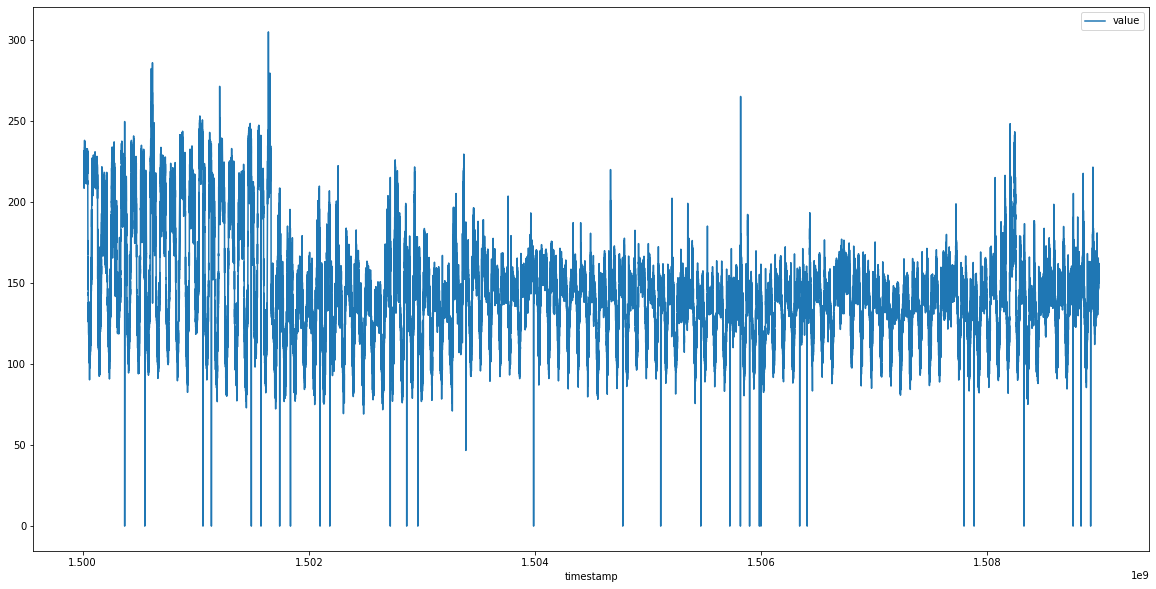

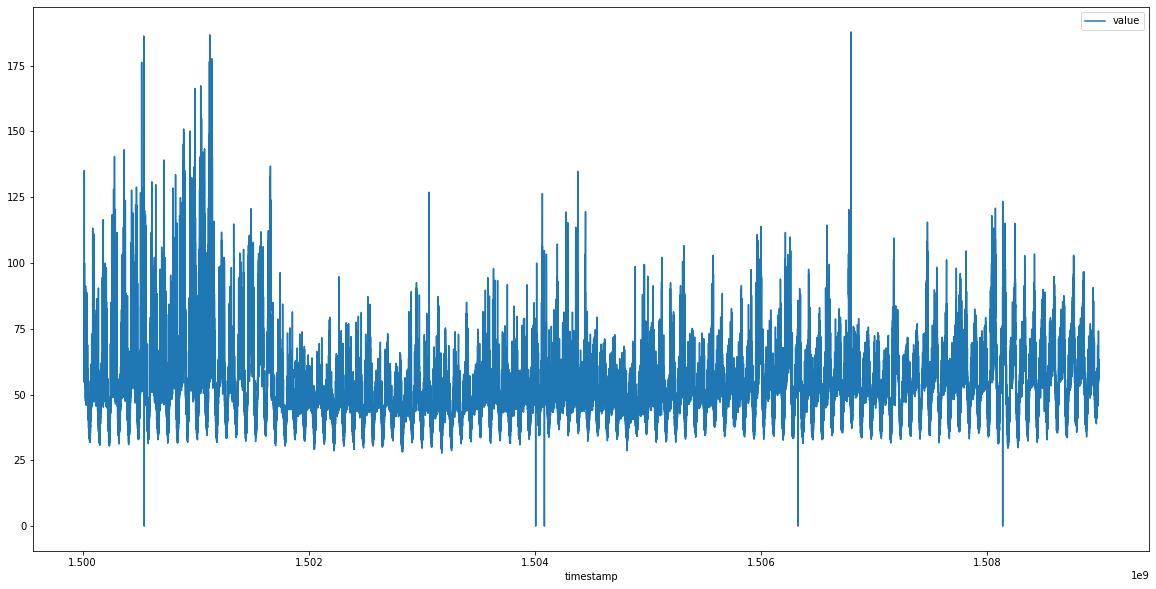

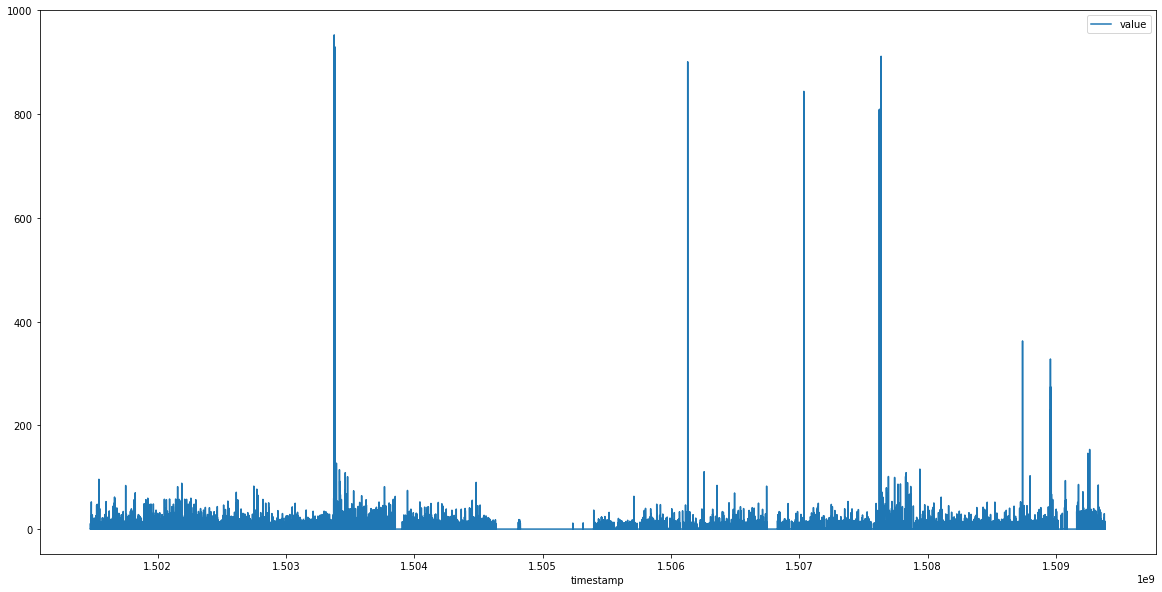

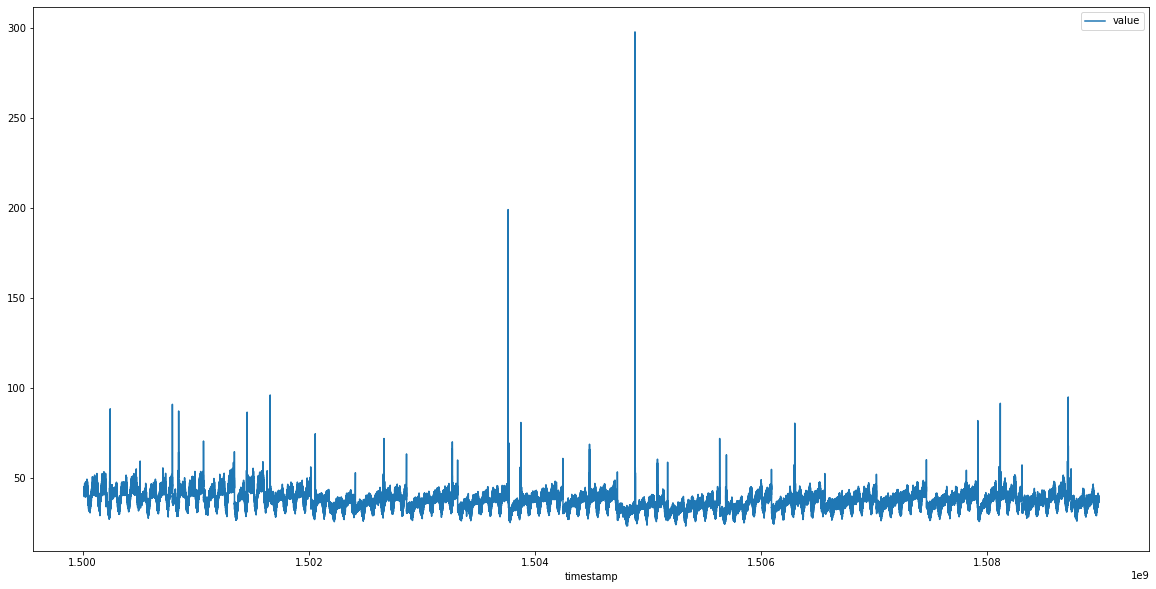

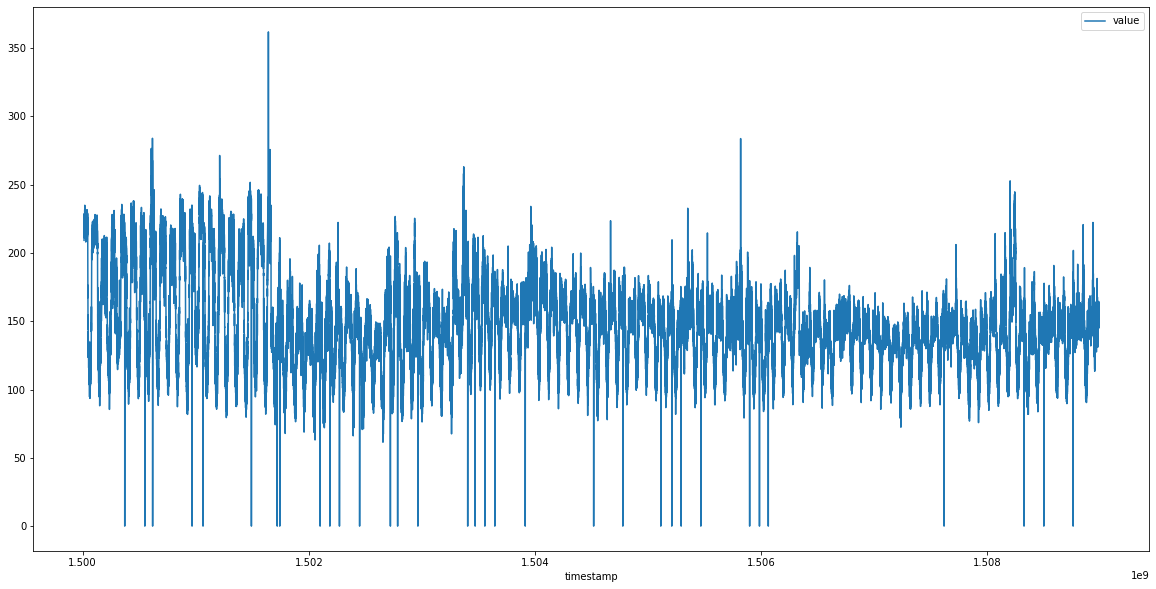

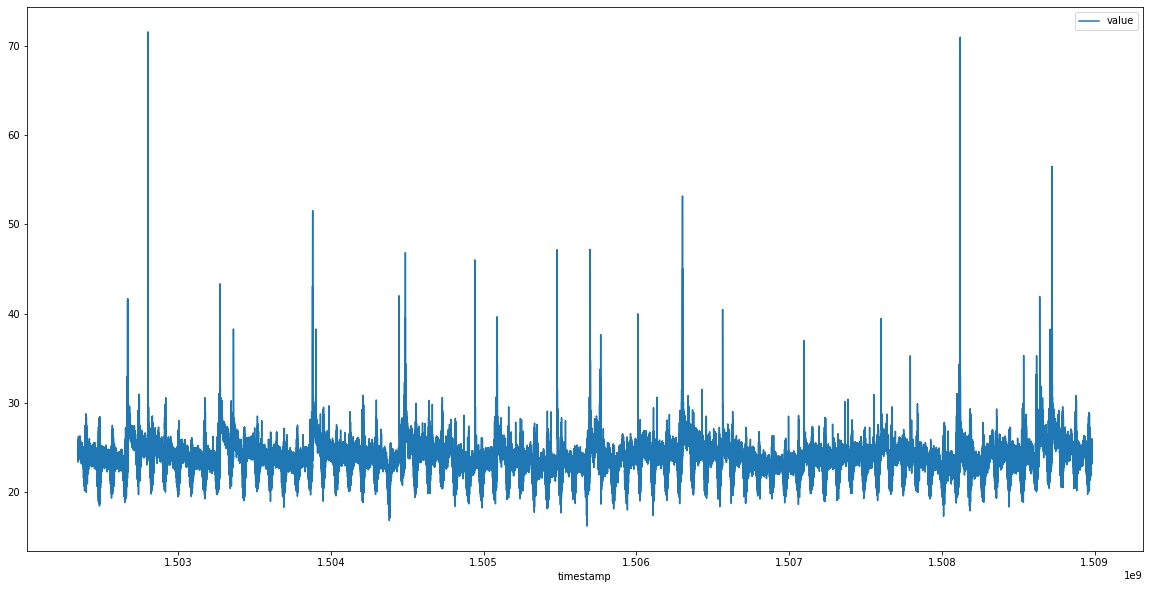

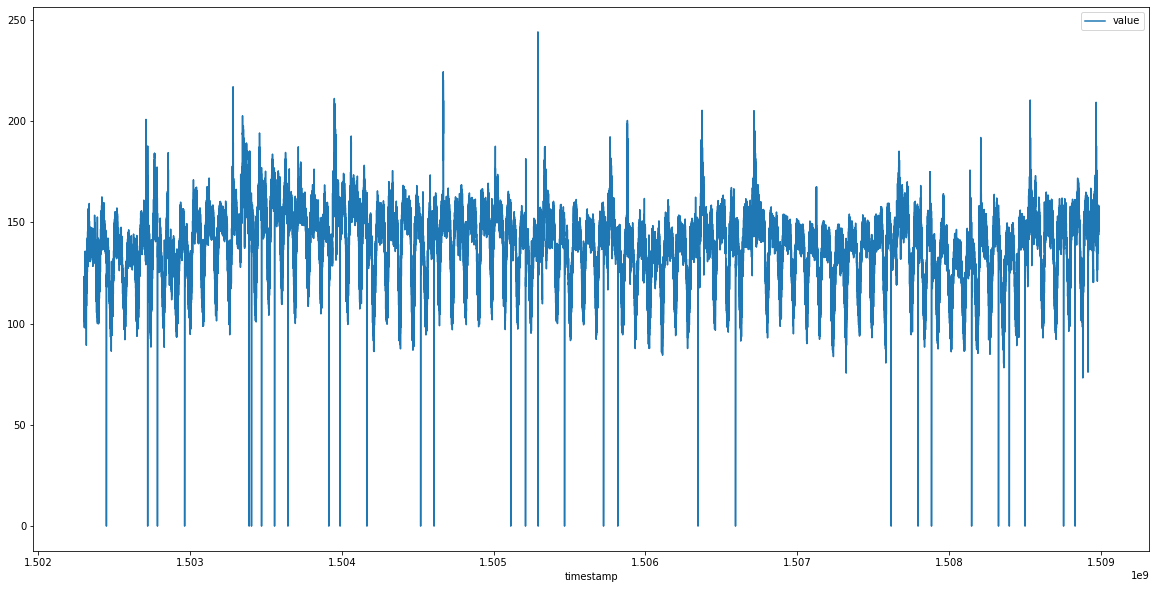

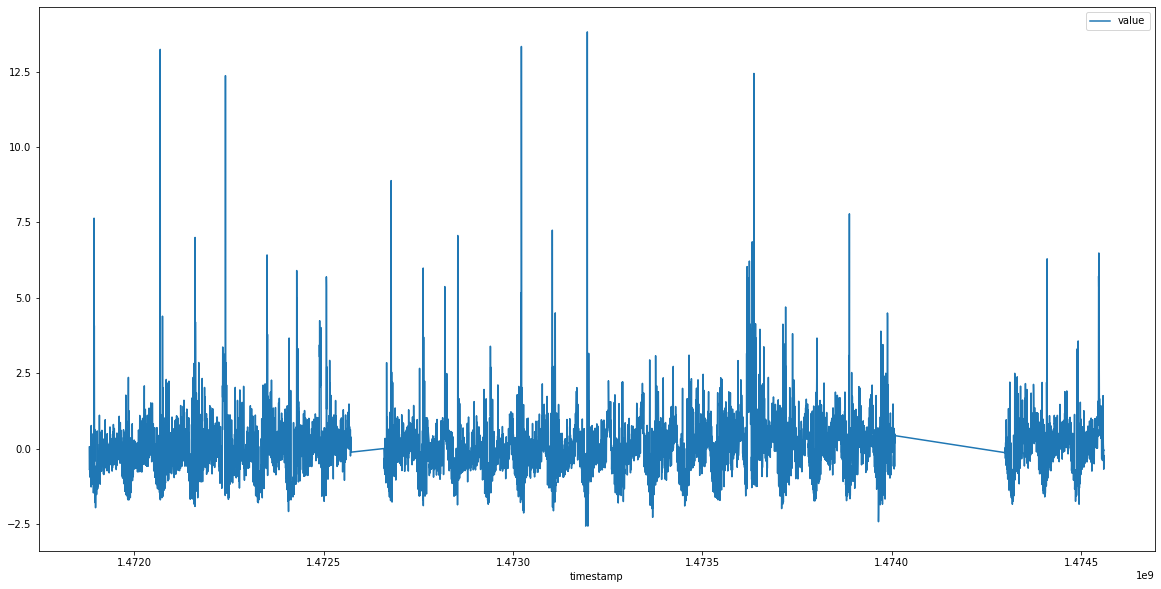

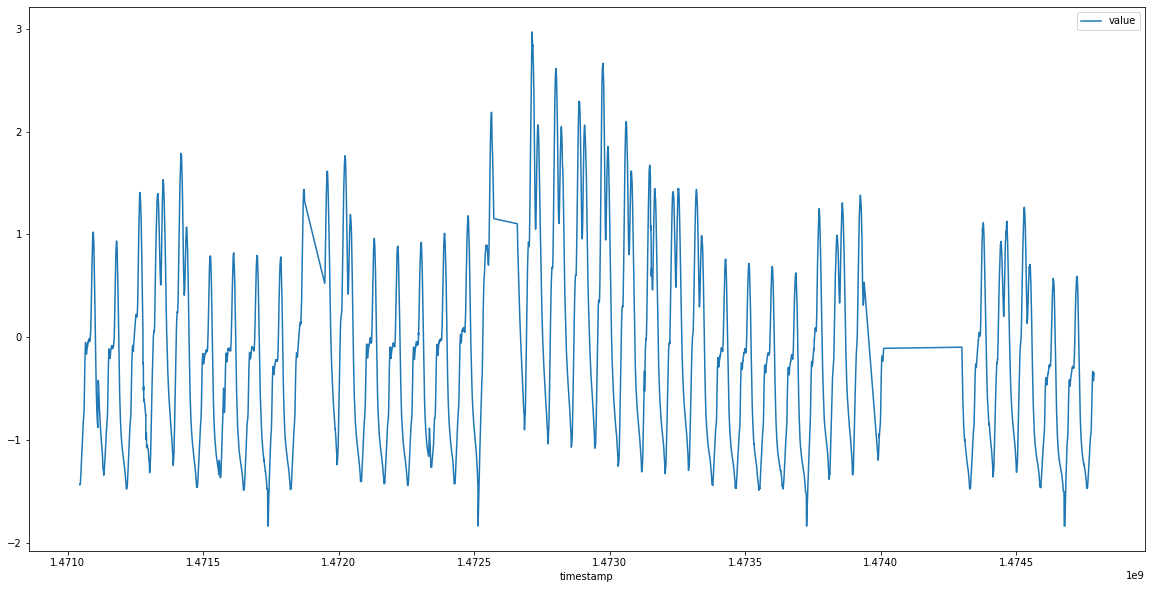

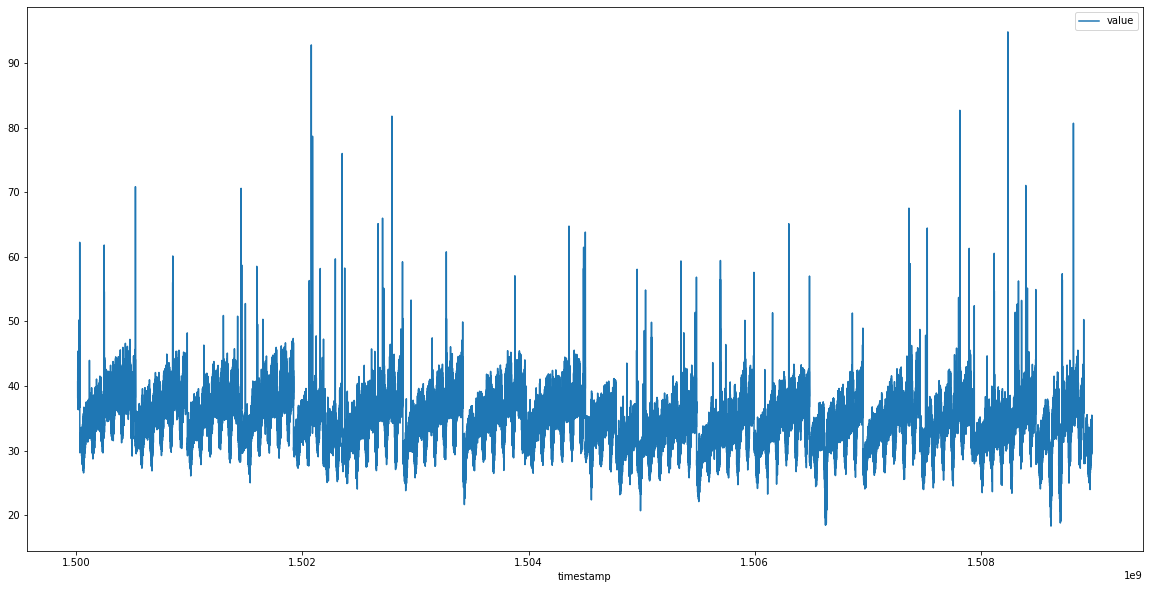

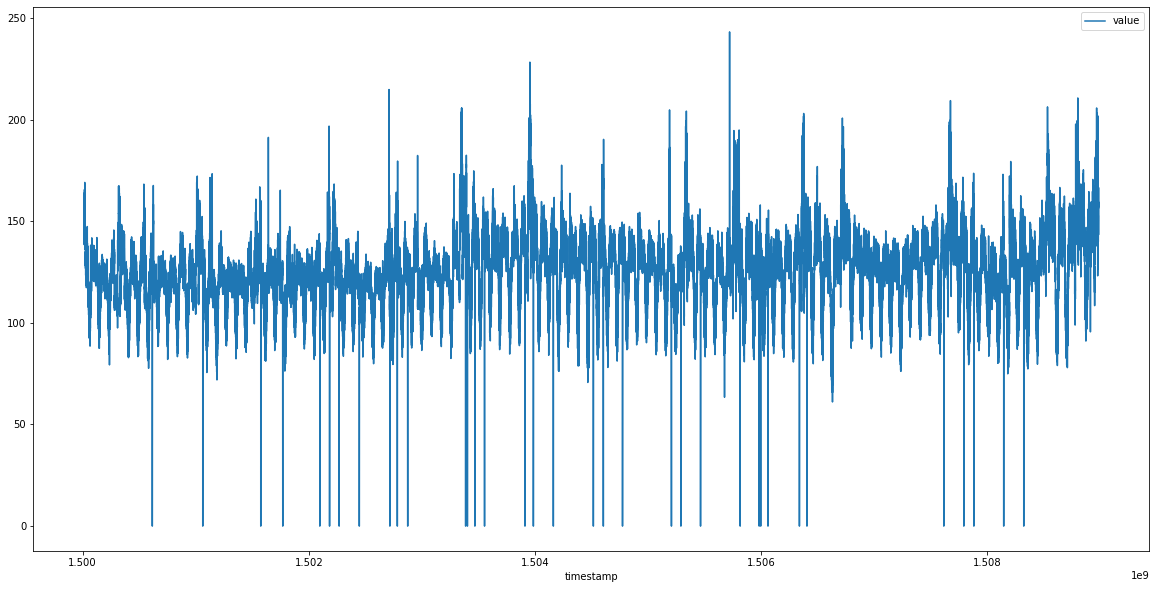

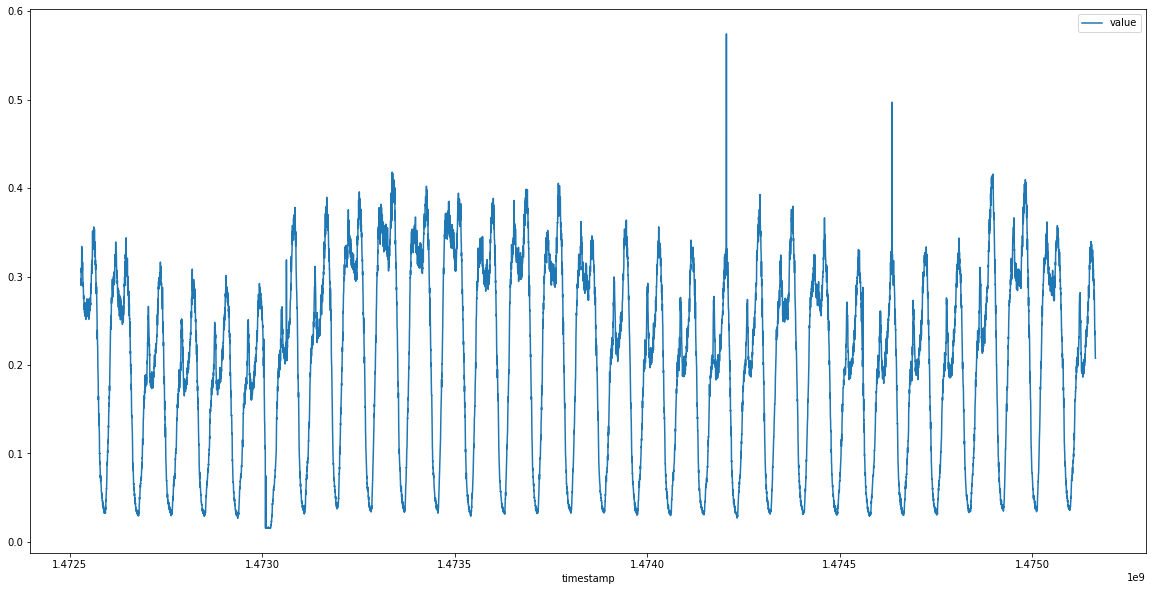

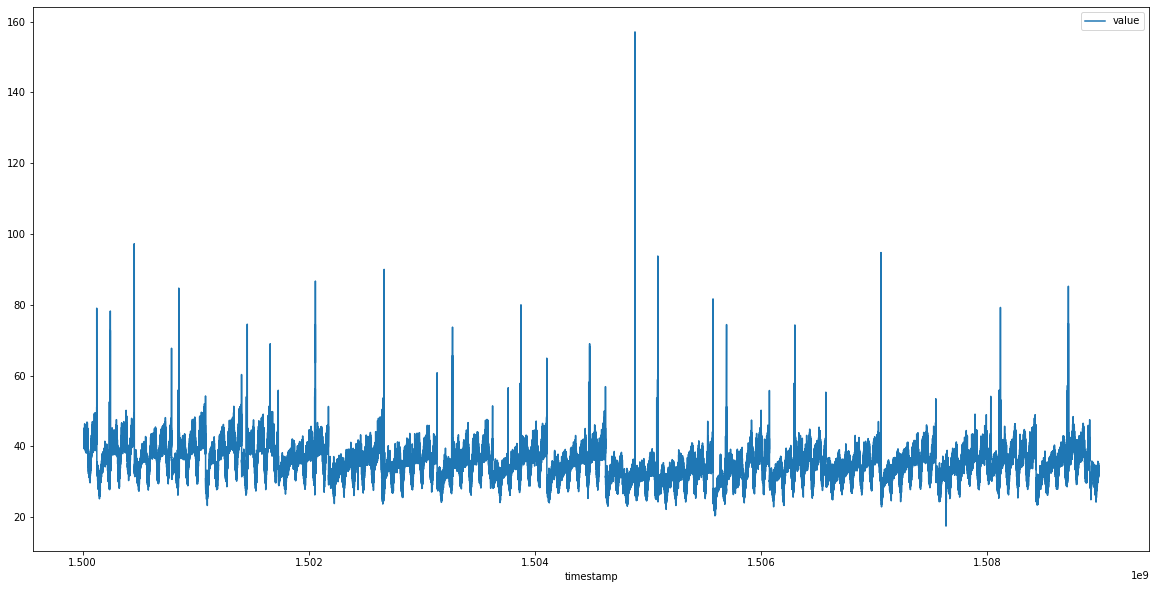

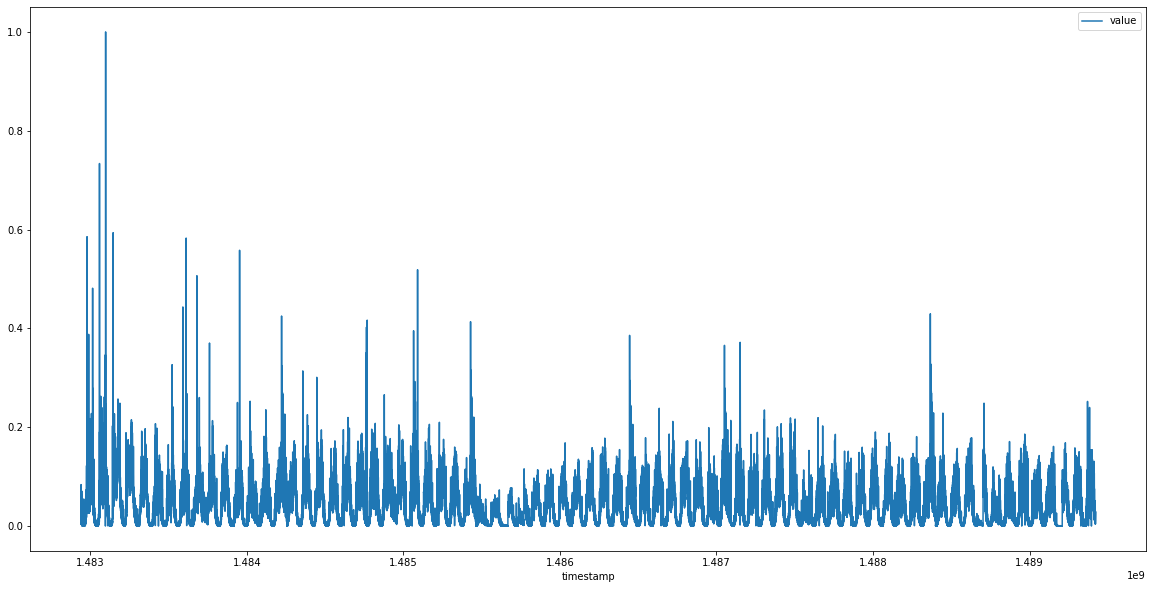

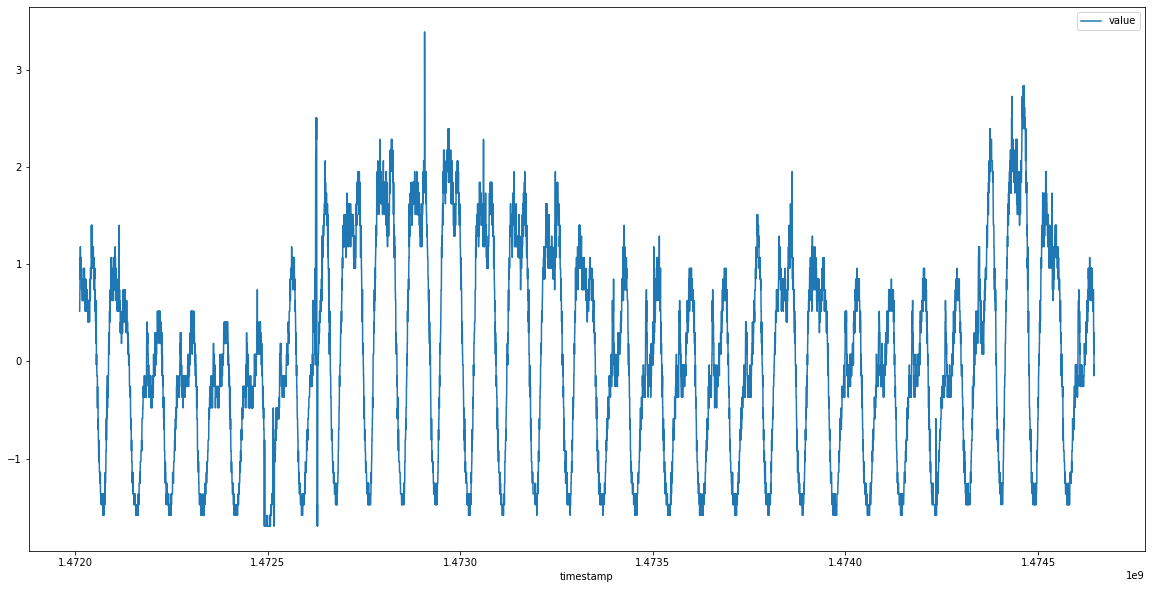

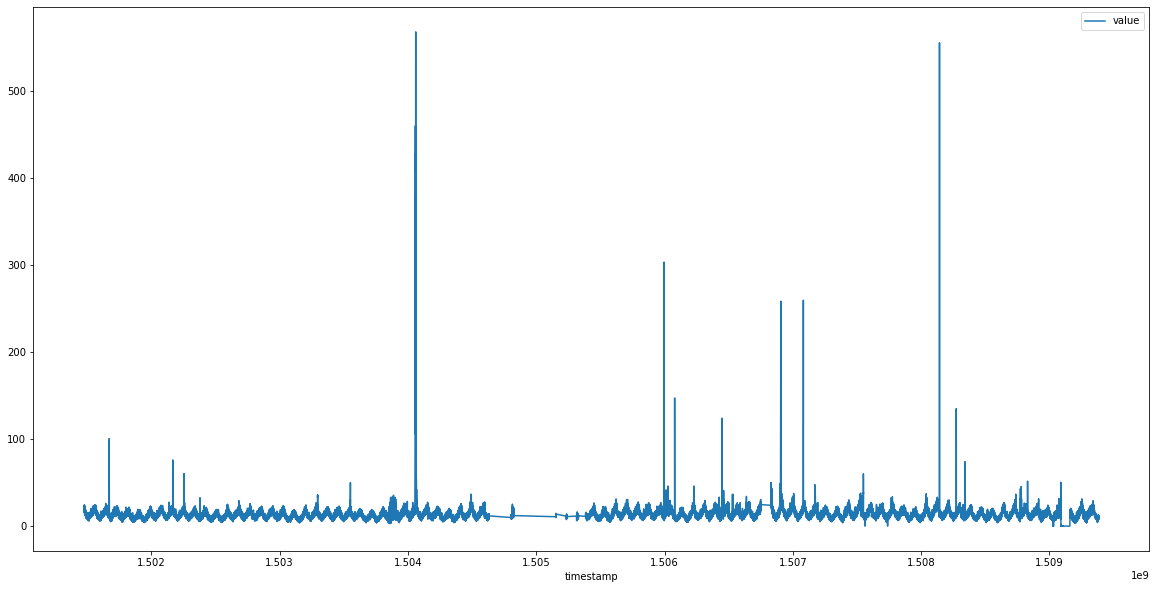

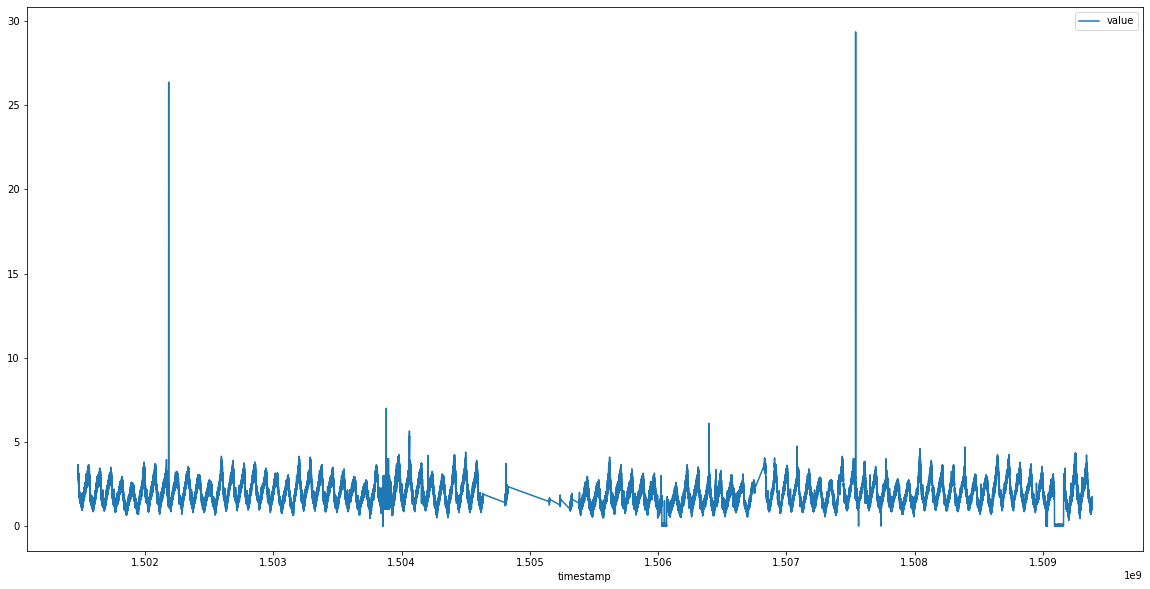

In [18]:
for df in test_dfs:
    df.plot(x="timestamp", y=["value"])
plt.show()